# 1. Introduction

### 1.1 About the problem
Death by Suicide is amoung the leading causes of death globally, particularly for persons between the ages of 15 - 49. Addressing this issue requires understanding the victims, what makes the similar or dissimilar, their demographics, etc.


### 1.2 - The Dataset Source

The dataset was obtained on kaggle.

This compiled dataset pulled from four other datasets linked by time and place, and was built to find signals correlated to increased suicide rates among different cohorts globally, across the socio-economic spectrum.

This dataset contains information on suicide rates between 1985 and 2015 for 100 countries in the world. Year 2016 is included in the data but it is assumed to be incomplete. 
Not all countries are present in all years. 
It is divided in age groups and gender. 

We have later added data on world temperature.

### 1.3 General Information
Original format: csv

**Dataset shape**: 27820 x 12 (rows x columns)
<br> 19456 missing values for HDI 

**Categorical Features**
- _Country_: A total of 101 countries are included in this dataset. Most countries in Asia are not included and considering we have 195 countries in the world today, this is a quite biased data for worldwide analysis.
- _Year_: The dataset goes from 1985 to 2016
- _Sex_: Male/female differentiation
- _Age_: Age is divided in five age intervals- 5-14, 15-24, 25-34, 35-54, 55-74 and 75+
- _Generation_: There are six generations included in this dataset. 

    - G.I. Generation: Born 1920 or before
    - Silent Generation: Born 1921 - 1945
    - Boomers Generation: Born 1946 - 1964
    - Generation X: Born 1965 - 1976
    - Millenials Generation: Born 1977 - 1995
    - Generation Z: Born 1996 - TBD

This data's level of detail is is a combination of Country+Year+Sex+Age, which is a subsample of the population (e.g. Canadian males of age between 15 and 25 in 1996). 
For each of those we have corresponding numerical features.

**Numerical Features**
- _Population size_: Number of people contained in each subsample 
- _Number of Suicides_: Number of suicides in each subsample 
- _Suicides per 100k people_: Number of suicides divided by the population size and multiplied by 100.000. This scales the number for better interpretation and allows you to make comparison between different subsamples. 
- _GDP for year_: Gross Domestic Product, a measure of the market value for a country-year combination. 
- _GDP per capita_: Obtained by dividing the GDP by the total population of the country for that year. 
- _HDI for year_ : Human Development Index, an index that measures life expectancy, income and education.


It’s important to note that looking at figures at a global/continent level might not truly be representative of the globe/continent for these reasons.

Comparing the raw suicide rates of countries may also lead to some issues - the definition of suicide (and the reliability that a death is recorded as suicide) will likely vary between countries.

However, trends over time (within countries) are likely to be reliable.

**Libraries used**
- statsmodels
- sklearn
- scipy
- matplotlib
- pycountry_convert
- seaborn

# 2. Data Preparation and Cleaning

Importing the necessary libraries

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sb
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy, math

Load the data and rename the columns for convenience

In [2]:
train = pd.read_csv('./master.csv', sep=',')
train.rename(columns = {'country':'Country', 'year':'Year', 'sex': 'Sex',
                       'age':'Age', 'suicides_no': 'suicides_no',
                       'population': 'population',
                       'suicides/100k pop' : 'suicides_per_100k',
                       'HDI for year': 'hdi',
                       ' gdp_for_year ($) ':'GDPYear',
                       'gdp_per_capita ($)': 'GDPpercapita',
                       'generation':'Generation'
                       }, inplace = True)

Getting the feel of features and samples. <br>
We see that HDI column has NaNs

In [3]:
train.head(10)

,Country,Year,Sex,Age,suicides_no,population,suicides_per_100k,country-year,hdi,GDPYear,GDPpercapita,Generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,Generation X


In [4]:
train.describe()

,Year,suicides_no,population,suicides_per_100k,hdi,GDPpercapita
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


We see that there are 19456 NaNs for HDI feature out of 27820. i.e Nearly, half of the Data for the feature is missing. We cannot fill so many values as this may bias our analysis. Hence, NaNs are NOT replaced. Only available values of HDI are used.

In [5]:
print('total NaNs  for HDI = {}'.format(train.hdi.isna().sum()))
print('% of NaNs for HDI = {}'.format(train.hdi.isna().sum() * 100 / train.shape[0]))

total NaNs  for HDI = 19456
% of NaNs for HDI = 69.9352983465133


We are dropping the columns that are not required for our analysis. <br>
Dropped features is - country-year <br>
We have also formatted the data in Age column for better plotting 
We have changed the datatype of features-Age and Generation from String to Categorical

In [6]:
#redundant column is dropped
train.drop(columns='country-year', inplace=True)
# 2016 data was removed (few countries had any, those that did often had data missing)
print(train.shape)
train.drop(train[train.Year==2016].index, axis=0, inplace=True)
print(train.shape)
train['Age']= train.Age.str.replace(' years','')

cats_age_to_order = ["5-14", 
                     "15-24",
                     "25-34", 
                     "35-54", 
                     "55-74", 
                     "75+" ]
cats_age_type = CategoricalDtype(categories=cats_age_to_order, ordered=True)
train['Age'] = train['Age'].astype(cats_age_type)

cats_generation_to_order = ["Generation Z",
                            "Millenials",
                            "Generation X",
                            "Boomers",
                            "Silent",                        
                            "G.I. Generation" ]
cats_generation_type = CategoricalDtype(categories=cats_generation_to_order, ordered=True)
train['Generation'] = train['Generation'].astype(cats_generation_type)

(27820, 11)
(27660, 11)


Seeing Histogram of data for every Country, we see that it is skewed right and we notice a few countries have very less data.<br> Let us identify and filter those counties from our train set

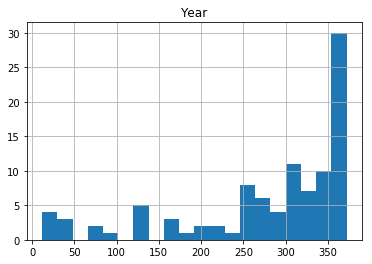

In [7]:
each_country = train.groupby(['Country'])['Year'].count()
each_country = each_country.reset_index()
each_country.hist(bins=20);

We find out the countries that have less than 5 years of data and filter them out. The Countries removed are Cabo Verde,Dominica,Macau,Bosnia and Herzegovina,Saint Kitts and Nevis,San Marino, Oman (due to lack of sufficient data)

In [8]:
each_country.sort_values('Year').head(10)

,Country,Year
17,Cabo Verde,12
27,Dominica,12
54,Macau,12
14,Bosnia and Herzegovina,24
75,Saint Kitts and Nevis,36
78,San Marino,36
64,Oman,36
95,United Arab Emirates,72
62,Nicaragua,72
92,Turkey,84


In [9]:
# 7 countries removed as they have <= 5 years of data
countries = train[(train.Country=='Cabo Verde') | (train.Country== 'Dominica') |
           (train.Country=='Macau') | (train.Country== 'Bosnia and Herzegovina') |
           (train.Country=='Oman') | (train.Country=='Saint Kitts and Nevis') | (train.Country== 'San Marino')].index
train.drop(countries, axis=0, inplace=True)
print(train.shape)

(27492, 11)


We are Adding a new Column 'Continent' for analysing trends for each Continent

In [10]:
# Generate Continent Column
def get_continent(c):
   continents = {
      'NA': 'North America',
      'SA': 'South America',
      'AS': 'Asia',
      'OC': 'Australia',
      'AF': 'Africa',
      'EU': 'Europe'

   }
   try:
      return continents[country_alpha2_to_continent_code(country_name_to_country_alpha2(c))]
   except:
         if c== 'Republic of Korea':
            return 'Asia'
         elif c == 'Saint Vincent and Grenadines':
            return 'North America'

train['Continent'] = train.Country.apply(lambda x: get_continent(x))

We have added a 'Decade' column to analyse trends for 3 decades from 1985 - 2015

In [11]:
# add Time column

train['Time'] = train['Year'].apply(lambda x: "1986 - 1995" if x <= 1995 
                                                               else ('1996 - 2005' if x <= 2005 else "2006 - 2015"))

# 2 Global Analysis
## 2.1 Global Trend

global average suicide rate from 1985 - 2015: 13.1 deaths (per 100k, per year)


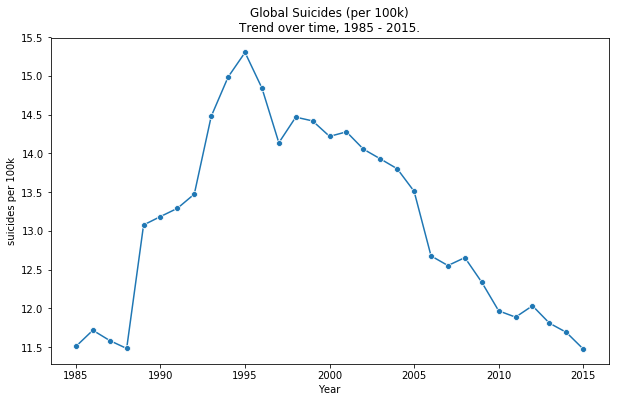

In [12]:
year_result =  pd.DataFrame({"suicides_per_100k": train.groupby(["Year"])['suicides_no'].sum() * 100000 / train.groupby(["Year"])['population'].sum()
                       },index=None)
year_result = year_result.reset_index()
plt.figure(figsize=(10, 6))
# ax = sb.relplot(x='Year', y='suicides_per_100k', kind = 'line', data = year_result, height = 6);
g = sb.lineplot(x='Year', y='suicides_per_100k',data = year_result, marker='o')
g.set(title='Global Suicides (per 100k)\nTrend over time, 1985 - 2015.', ylabel='suicides per 100k');

print('global average suicide rate from 1985 - 2015: {} deaths (per 100k, per year)'.format(round(year_result['suicides_per_100k'].mean(),1)))

In [13]:
# Data available before 1990
print('Data available before 1990 = {} data points'.format(year_result[year_result.Year<1990].shape[0]))

Data available before 1990 = 5 data points


In [14]:
# The highest suicide rate ever recorded in a demographic(per 100k population).

print('The highest suicide rate ever recorded in a demographic (for 1 year) is {} males (per 100k population)'.format(abs(round(train.sort_values('suicides_per_100k', ascending=False).iloc[0]['suicides_per_100k'],1))))

The highest suicide rate ever recorded in a demographic (for 1 year) is 225.0 males (per 100k population)


**Insights**

- Peak suicide rate was **15.3** deaths per 100k in **1995**
- Decreased steadily, to **11.5** per 100k in **2015** (~25% decrease)
- Rates are only now returning to their pre-90’s rates
- **Limited data in the 1980’s**, so it’s hard to say if rate then was truly representative of the global population

## 2.2  By Continent

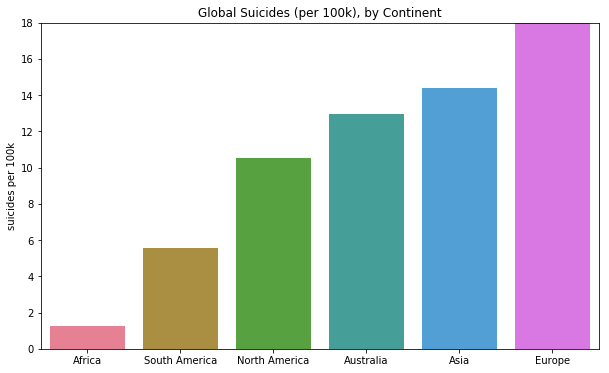

In [15]:
continentresults = pd.DataFrame({"suicides_per_100k": train.groupby(["Continent"])['suicides_no'].sum() / train.groupby(["Continent"])['population'].sum() * 100000
                       },index=None)
continentresults = continentresults.reset_index().sort_values('suicides_per_100k')

plt.figure(figsize=(10, 6))
g = sb.barplot(x='Continent', y= 'suicides_per_100k' ,ci = None, palette="husl"
              ,data = continentresults)

g.set(title='Global Suicides (per 100k), by Continent',xlabel='',ylabel='suicides per 100k')

g.set_ylim(0, 18);

In [16]:
continent_time_results = pd.DataFrame({"suicides_per_100k": train.groupby(["Year","Continent"])['suicides_no'].sum() / train.groupby(["Year","Continent"])['population'].sum() * 100000
                       },index=None)

continent_time_results = continent_time_results.reset_index().sort_values('suicides_per_100k')

Global Suicides (per 100k), by Continent


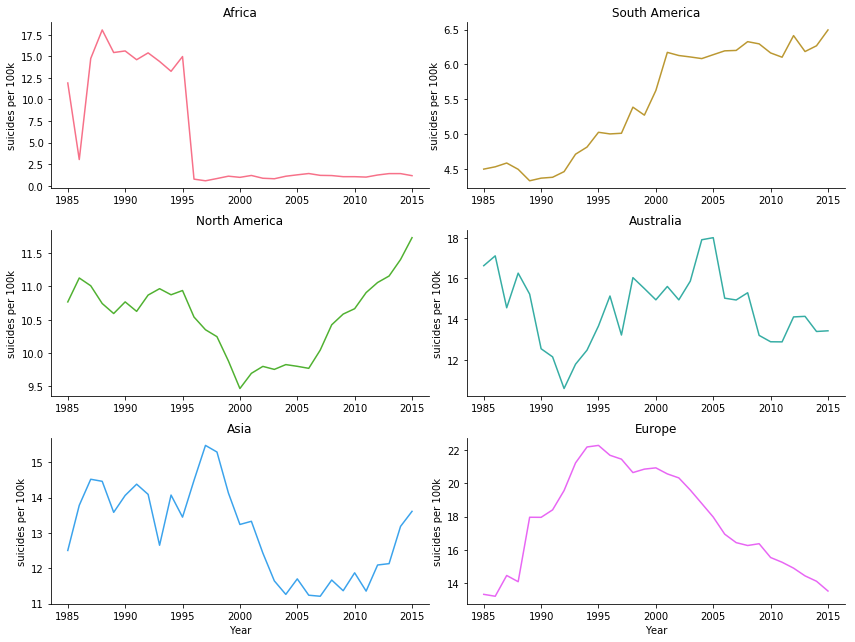

In [17]:
print('Global Suicides (per 100k), by Continent')
g = sb.FacetGrid(continent_time_results, col = 'Continent' , height=3, aspect =2,
                 col_wrap=2,sharex=False, hue ='Continent', sharey=False,  palette="husl")
g.set(xticks = np.arange(1985,2020,5))
g = g.map(sb.lineplot, "Year", "suicides_per_100k");

g.axes[0].set(ylabel ='suicides per 100k')
g.axes[1].set(ylabel ='suicides per 100k')
g.axes[2].set(ylabel ='suicides per 100k')
g.axes[3].set(ylabel ='suicides per 100k')
g.axes[4].set(ylabel ='suicides per 100k')
g.axes[5].set(ylabel ='suicides per 100k')

g.axes[0].set_title('Africa');
g.axes[1].set_title('South America');
g.axes[2].set_title('North America');
g.axes[3].set_title('Australia');
g.axes[4].set_title('Asia');
g.axes[5].set_title('Europe');

**Insights**

- European rate highest overall, but has steadily decreased ~40% since 1995
- The trendline for Africa is due to poor data quality - just 3 countries have provided data
- Americas' upward trends are more concerning

## 2.3 By Gender

Global suicides (per 100k), by Gender



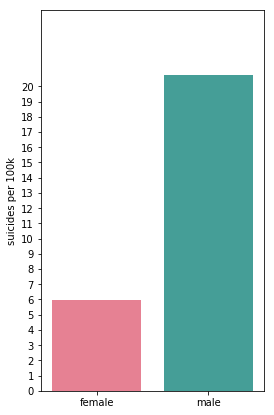

In [18]:
sexresults = pd.DataFrame({"suicides_per_100k": train.groupby(["Sex"])['suicides_no'].sum()* 100000 / train.groupby(["Sex"])['population'].sum() 
                       },index=None)
sexresults = sexresults.reset_index().sort_values('suicides_per_100k')
print('Global suicides (per 100k), by Gender\n')
plt.figure(figsize=(4, 7))
g = sb.barplot(x='Sex', y= 'suicides_per_100k' ,ci = None, palette="husl"
              ,data = sexresults)

g.set(xlabel='', ylabel='suicides per 100k')
g.set_yticks(np.arange(0,21,1))
g.set_ylim(0, 25);

Trends Over Time, by Gender


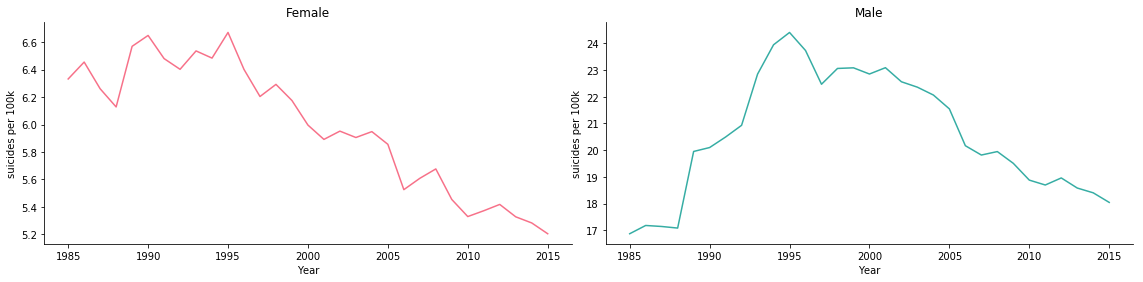

In [19]:
print('Trends Over Time, by Gender')
sex_time_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Year',"Sex"])['suicides_no'].sum() / train.groupby(['Year',"Sex"])['population'].sum() * 100000
                       },index=None)

sex_time_results = sex_time_results.reset_index().sort_values('suicides_per_100k')

g = sb.FacetGrid(sex_time_results, col = 'Sex' , height=4, aspect =2,
                 col_wrap=2,sharex=False, hue ='Sex', sharey=False,  palette="husl");
g = g.map(sb.lineplot, "Year", "suicides_per_100k");
g.axes[0].set(ylabel='suicides per 100k')
g.axes[1].set(ylabel='suicides per 100k')
# g.set(xticks=x_ticks);
g.axes[0].set_title('Female');
g.axes[1].set_title('Male');

**Insights**

- Globally, the rate of suicide for men has been ~3.5x higher
- Both male & female suicide rates peaked in 1995, declining since
- This ratio of 3.5 : 1 (male : female) has remained relatively constant since the mid 90’s
- However, during the 80’s this ratio was as low as 2.7 : 1 (male : female)

## 2.4 By Age

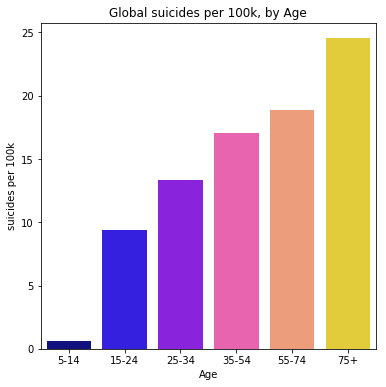

In [20]:
age_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Age'])['suicides_no'].sum() / train.groupby(['Age'])['population'].sum() * 100000
                       },index=None)

age_results = age_results.reset_index().sort_values('suicides_per_100k')

plt.figure(figsize=(6, 6))
g = sb.barplot(x='Age', y= 'suicides_per_100k' ,palette='gnuplot2', ci = None,data = age_results)

g.set(ylabel='suicides per 100k',title='Global suicides per 100k, by Age');

Trends Over Time, by Age


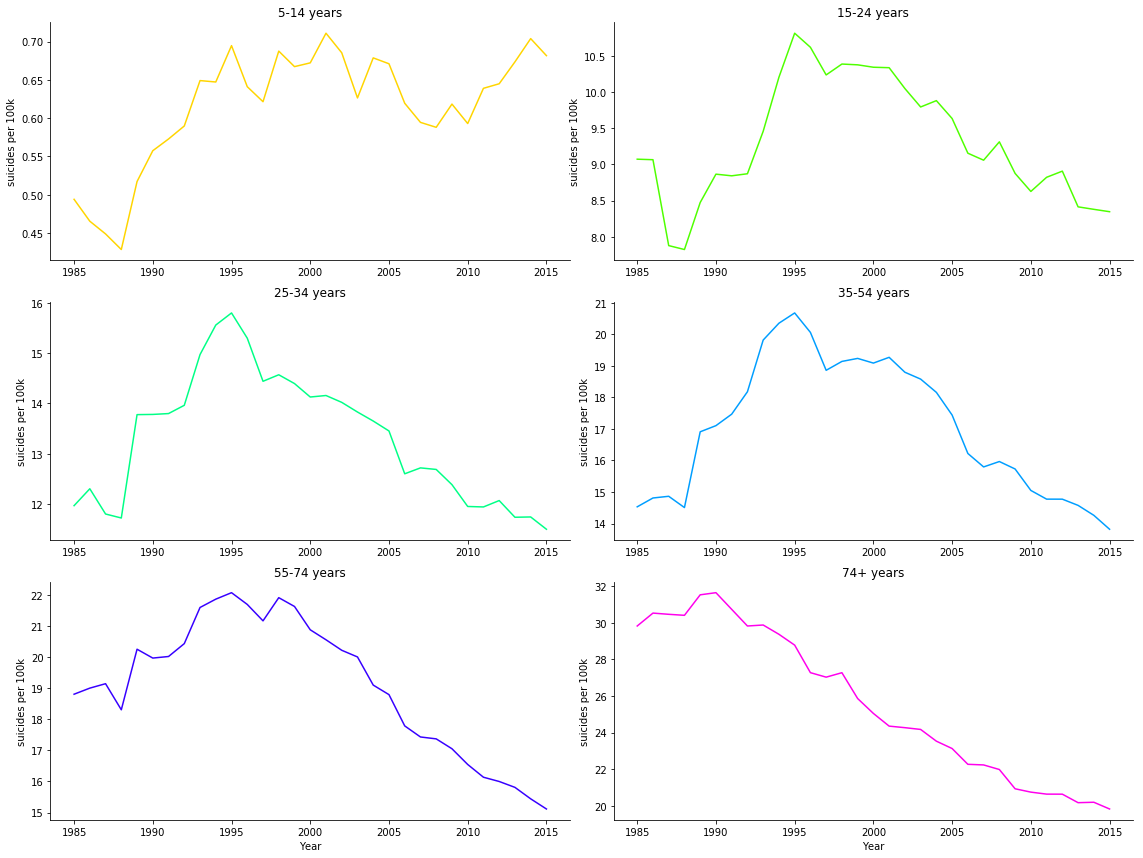

In [21]:
age_time_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Year','Age'])['suicides_no'].sum() / train.groupby(['Year',"Age"])['population'].sum() * 100000
                       },index=None)

age_time_results = age_time_results.reset_index().sort_values('suicides_per_100k')
print('Trends Over Time, by Age')
g = sb.FacetGrid(age_time_results, col = 'Age' , height=4, aspect =2, palette='hsv',
                 col_wrap=2,sharex=False, hue ='Age', sharey=False);
g = g.map(sb.lineplot, "Year", "suicides_per_100k");
# g.set(xticks=x_ticks);
g.axes[0].set(ylabel='suicides per 100k',title='5-14 years');
g.axes[1].set(ylabel='suicides per 100k',title='15-24 years');
g.axes[2].set(ylabel='suicides per 100k',title='25-34 years');
g.axes[3].set(ylabel='suicides per 100k',title='35-54 years');
g.axes[4].set(ylabel='suicides per 100k',title='55-74 years');
g.axes[5].set(ylabel='suicides per 100k',title='74+ years');

## Insights

 - Globally, the likelihood of suicide increases with age
 - After 1995, suicide rate for everyone aged >= 15 has been linearly decreasing
 - The suicide rate of those aged 75+ has dropped by more than 50% since 1990
 - Suicide rate in the ‘5-14’ category remains roughly static and small (< 1 per 100k per year)

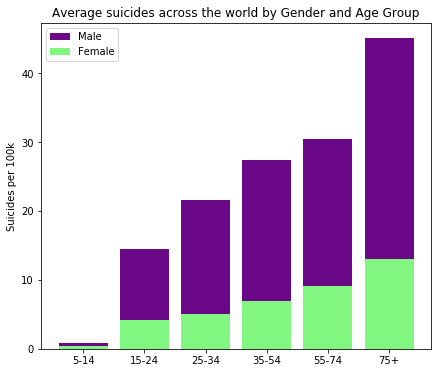

In [22]:
sex_age_df = train[['Sex', 'Age', 'suicides_no','population']].groupby(['Sex', 'Age']).sum().reset_index()
sex_age_df['suicides_per_100k'] = sex_age_df['suicides_no'] * 100000 / sex_age_df['population']

age_groups = sex_age_df['Age'].unique()
male_suicides = sex_age_df[sex_age_df['Sex'] == 'male']['suicides_per_100k']
female_suicides = sex_age_df[sex_age_df['Sex'] == 'female']['suicides_per_100k']
plt.figure(figsize=(7, 6))
plt.bar(age_groups, male_suicides, label='Male', color='#6A0888');
plt.bar(age_groups, female_suicides, label='Female', color='#81F781');

plt.title('Average suicides across the world by Gender and Age Group');

plt.ylabel('Suicides per 100k');
plt.legend();

#### Key Insights:
- Globally, suicide rates for men increase with age.
- Men across all age groups have higher suicide rate.

## 2.5 By Country

### 2.5.1 Overall

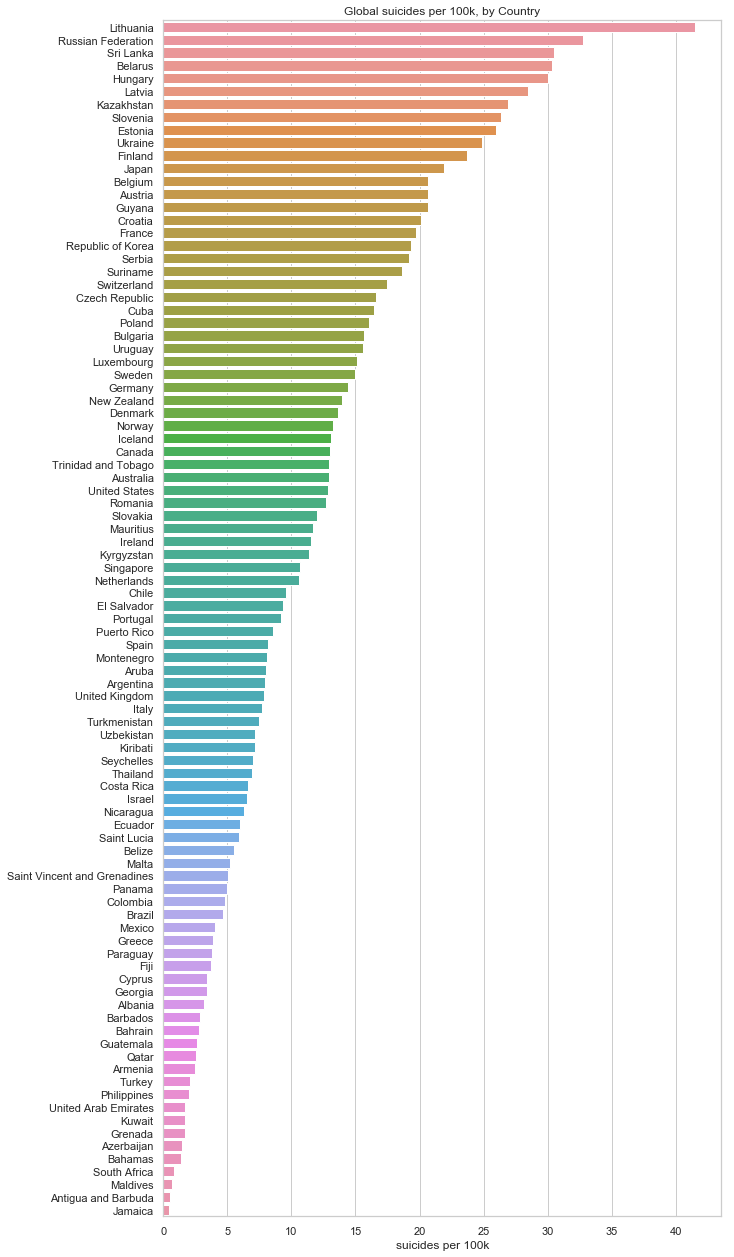

In [23]:
sb.set(style="whitegrid")
country_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Country'])['suicides_no'].sum() / train.groupby(['Country'])['population'].sum() * 100000
                       },index=None)

country_results = country_results.reset_index().sort_values('suicides_per_100k', ascending = False)

plt.figure(figsize=(10,22))
g = sb.barplot(y='Country', x= 'suicides_per_100k' ,ci = None,data = country_results)
g.set(ylabel='', xlabel='suicides per 100k')
g.set_title('Global suicides per 100k, by Country');

**Insights**

- Lithuania’s rate has been highest by a large margin: > 41 suicides per 100k (per year)
- Large overrepresentation of European countries with high rates, few with low rates

It’s important to note that looking at figures at a global/continent level might not truly be representative of the globe/continent for these reasons.

Comparing the raw suicide rates of countries may also lead to some issues - the definition of suicide (and the reliability that a death is recorded as suicide) will likely vary between countries.

However, trends over time (within countries) are likely to be reliable. We address this next.

### 2.5.2 Linear Trends

We are interested in how the suicide rate is changing over time within each country. <br>
In other words: as time goes on, We look for countries where the suicide rate is linearly increasing or decreasing over time. These can then be rank ordered by their their rate of change as time goes on.


In [24]:
trend_df = train.groupby(['Country','Year'])['suicides_no','population'].sum().reset_index()
trend_df['suicide_rate'] = trend_df['suicides_no']*100000 / trend_df['population']
# dm = dm[dm['suicides_no'].notnull()]
trends = []
for country in trend_df.Country.unique():
    country_trend = trend_df[trend_df['Country'] == country]
    X = np.array(country_trend['Year']).reshape([-1,1])
    y = np.array(country_trend['suicide_rate']).reshape([-1,1])
    
    model = LinearRegression()
    results = model.fit(X,y).coef_[0][0]
    trends.append([country,results])

    
df_trends = pd.DataFrame(trends,columns=['Country','factor']).sort_values(by='factor')
decrease_trends = list(df_trends['Country'].head(8))
increase_trends = list(df_trends['Country'].tail(5))

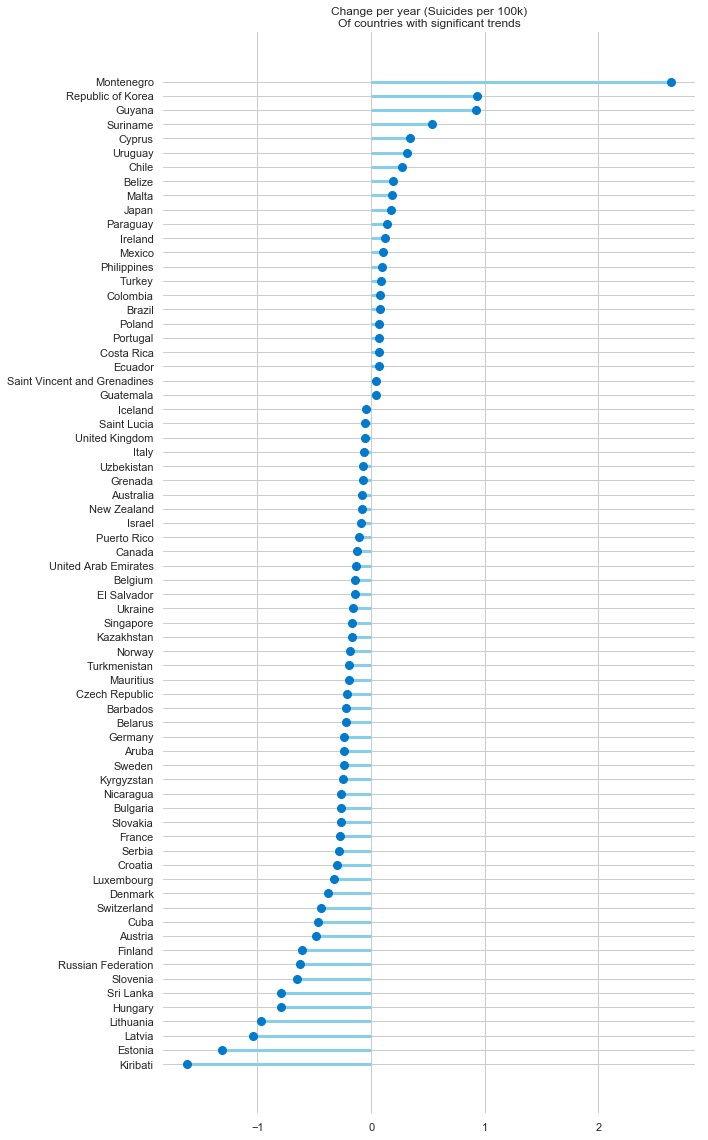

In [25]:
df_trends = df_trends[~df_trends.factor.between(-0.04, 0.04)]
countries = df_trends.Country.unique()

ax = plt.figure(figsize=(10,16));

ax1 = plt.hlines(y=countries, xmin=0, xmax=df_trends['factor'], color='skyblue', linewidth=3)
ax2 = plt.plot(df_trends['factor'], countries, "o", markersize=8, color='#007acc')

plt.title('Change per year (Suicides per 100k)\nOf countries with significant trends')

plt.tight_layout()
plt.yticks(countries)

plt.box(False)

In [26]:
print('% of total countries showing descreasing trend ={}'.format(df_trends[df_trends.factor<0].shape[0] *100 / df_trends.shape[0]))
# df_trends[df_trends.factor<0].shape   #70

% of total countries showing descreasing trend =67.14285714285714


**Insights**

- ~1/2 of all countries suicide rates are changing linearly as time progresses
- ~2/3 of these countries are decreasing
- Overall, this is painting a positive picture

Let us analyse the trends for few countries with Steepest increase and countries with steepest descrease in suicide rates seperately.

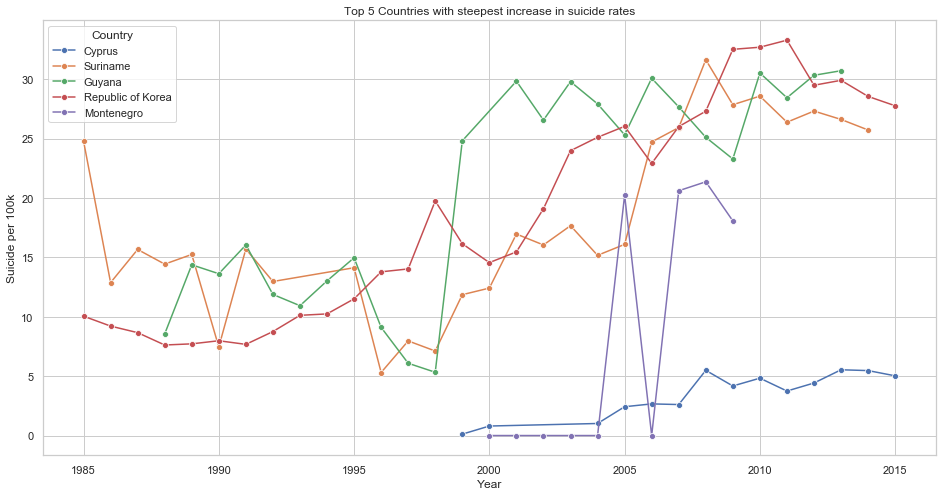

In [27]:
# Countries with increasing trend
plt.figure(figsize=(16,8))
legend = []

for country in increase_trends:
    country_trend = trend_df[trend_df['Country'] == country]
    g = sb.lineplot(x="Year", y="suicide_rate",data=country_trend,marker='o')
    legend.append(country)

plt.legend(title='Country', loc='upper left', labels=legend)
g.set(ylabel='Suicide per 100k', xlabel='Year', title = 'Top 5 Countries with steepest increase in suicide rates')
plt.show()

In [28]:
print('Suicide Rate of Guyana in 1998 = {}'.format(trend_df[(trend_df.Country=='Guyana') & (trend_df.Year==1998)]['suicide_rate']))
print('Suicide Rate of Guyana in 1998 = {}'.format(trend_df[(trend_df.Country=='Guyana') & (trend_df.Year==1999)]['suicide_rate'] ))

Suicide Rate of Guyana in 1998 = 923    5.326523
Name: suicide_rate, dtype: float64
Suicide Rate of Guyana in 1998 = 924    24.806192
Name: suicide_rate, dtype: float64


**Insights**

-  Korea shows the most concerning upward trend - an increase in suicide of 0.931 people (per 100k, per year) - the steepest increase globally
- Guyana is similar, at + 0.925 people (per 100k, per year)
- Between 1998 and 1999 Guyana’s rate increased enormously (5.3 to 24.8), 
- The historical data for Guyana seems questionable - it’s known for very high suicide rates but the spike seems unnatural

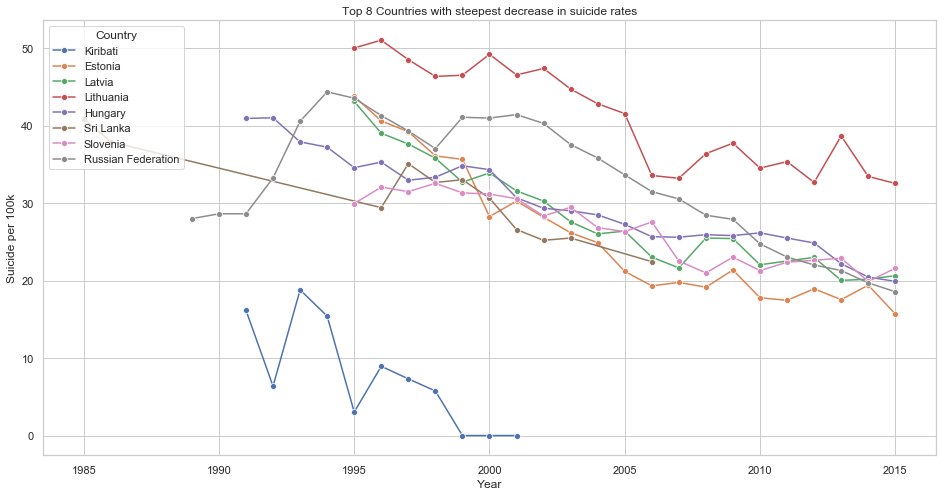

In [29]:
# Countries with decreasing trend
plt.figure(figsize=(16,8))
legends = []
# sb.set_palette(palette='gist_yarg')
for country in decrease_trends:
    country_trend = trend_df[trend_df['Country'] == country]
    g = sb.lineplot(x="Year", y="suicide_rate", data=country_trend , marker='o')
    legends.append(country)

plt.legend(title='Country', loc='upper left', labels=legends)
g.set(ylabel='Suicide per 100k', xlabel='Year', title = 'Top 8 Countries with steepest decrease in suicide rates')
plt.show()

In [30]:
# print('Estonia suicide rate in 1995={}'.format(trend_df[(trend_df.Country=='Estonia') & (trend_df.Year==1995)]['diff']))
print('Estonia Trend for 1995 and 2015')
trend_df[(trend_df.Country=='Estonia') & ((trend_df.Year==1995) | (trend_df.Year==2015))]

Estonia Trend for 1995 and 2015


,Country,Year,suicides_no,population,suicide_rate
688,Estonia,1995,594,1356651,43.784289
708,Estonia,2015,195,1243450,15.682175


**Insights**

- Estonia shows the most positive trend - every year, ~1.31 less people (per 100k) commit suicide - the steepest decrease globally
- Between 1995 and 2015, this drops from 43.8 to 15.7 per 100k (per year) - a 64% decrease
- The Russian Federation trend is interesting, only beginning to drop in 2002. Since then it has decreased by ~50%.

## 2.6 Gender differences, by Continent

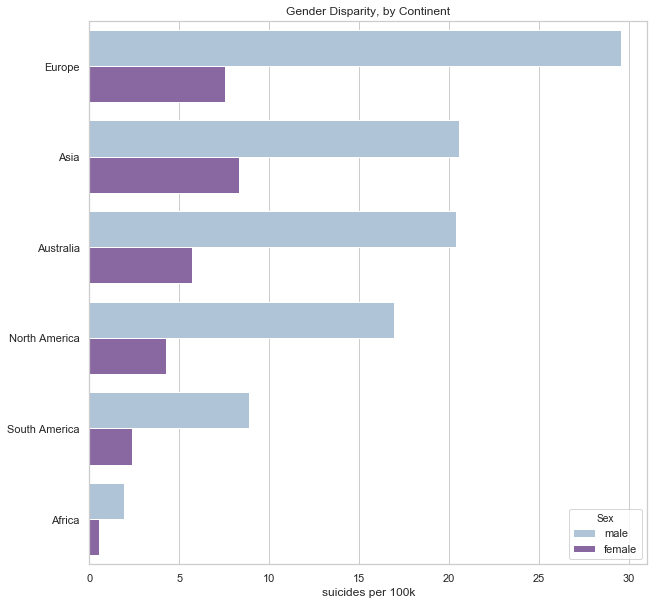

In [31]:
sb.set(style="whitegrid")
gender_continent_results =  pd.DataFrame({"suicides_per_100k": train.groupby(['Sex','Continent'])['suicides_no'].sum() 
                                          / train.groupby(['Sex','Continent'])['population'].sum() * 100000 })
gender_continent_results = gender_continent_results.reset_index().sort_values('suicides_per_100k', ascending = False)

plt.figure(figsize=(10,10))
g = sb.barplot(y='Continent', x= 'suicides_per_100k', hue = 'Sex' ,palette='BuPu',ci = None,
               data = gender_continent_results)

g.set(title='Gender Disparity, by Continent', xlabel='suicides per 100k', ylabel="");

**Insights**

- European men were at the highest risk between 1985 - 2015, at ~ 30 suicides (per 100k, per year)
- Asia had the smallest overrepresentation of male suicide - the rate was ~2.5x as high for men
- Comparatively, Europe’s rate was ~3.9x as high for men

## 2.7 Gender differences, by Country

In [32]:
country_wide = train[['suicides_per_100k','Country','suicides_no','population']]
country_wide = country_wide[country_wide.Country.isin(df_trends.Country)]
country_wide = pd.DataFrame({'suicides_no': country_wide.groupby(['Country'])['suicides_no'].sum()})

country_wide = pd.concat([country_wide,country_wide], axis = 0)
country_wide = country_wide.sort_values('Country')
country_wide = country_wide.reset_index()
sex_country_wide = train[['Sex','suicides_per_100k','Country','suicides_no','population']]
sex_country_wide = sex_country_wide[sex_country_wide.Country.isin(df_trends.Country)]

sex_country_wide = pd.DataFrame({'suicides_no': sex_country_wide.groupby(['Country','Sex'])['suicides_no'].sum()})
sex_country_wide = sex_country_wide.sort_values('Country')
sex_country_wide = sex_country_wide.reset_index()

sex_country_wide['prop'] = sex_country_wide['suicides_no'] * 100/(country_wide['suicides_no'])

sex_country_wide.loc[sex_country_wide.Sex=='male','prop'] = 100

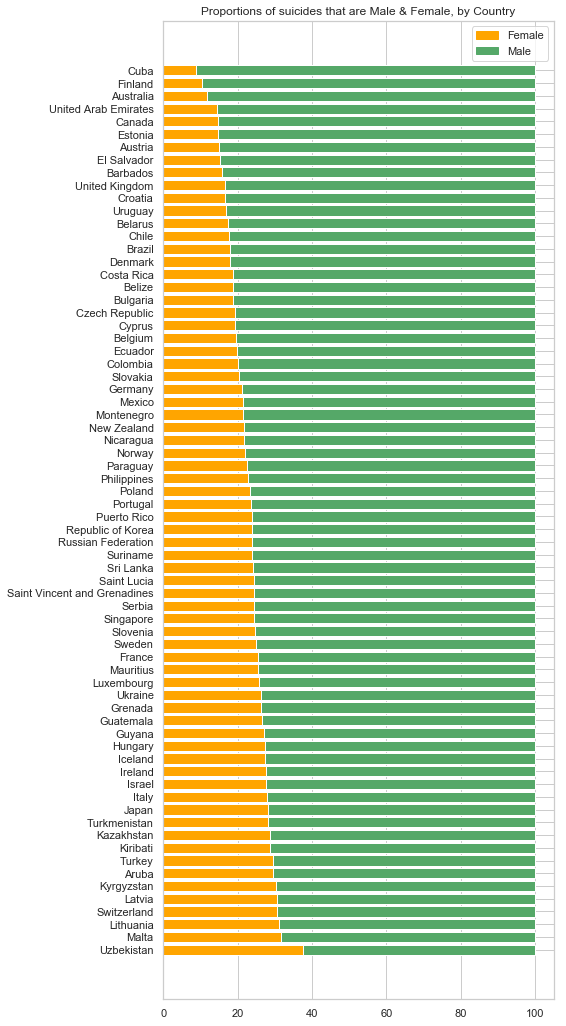

In [33]:
orange = mpatches.Patch(color='orange', label='Female')
green = mpatches.Patch(color='g', label='Male')

sex_country_wide = sex_country_wide.sort_values('prop', ascending=False)
y_pos = sex_country_wide.Country.unique()
bottomdata = sex_country_wide[sex_country_wide.Sex=='male']['prop']     #[100] * len(greenBars)                   #greenBars
topdata = sex_country_wide[sex_country_wide.Sex=='female']['prop']

fig = plt.figure(figsize=(7,18));
ax = fig.add_subplot(111);
ax.title.set_text('Proportions of suicides that are Male & Female, by Country')
ax.barh(y_pos, bottomdata,color='g',align='center');
ax.barh(y_pos, topdata,color='orange',align='center');
ax.legend(handles=[orange,green]);

**Insights**

- The overrepresentation of men in suicide deaths appears to be universal, and can be observed to varying extents in every country
- As per the gender paradox on suicidal behaviour, whilst women are more likely to suffer from depression and suicidal thoughts, men are more likely to die from suicide

## 2.8 Age differences, by Continent

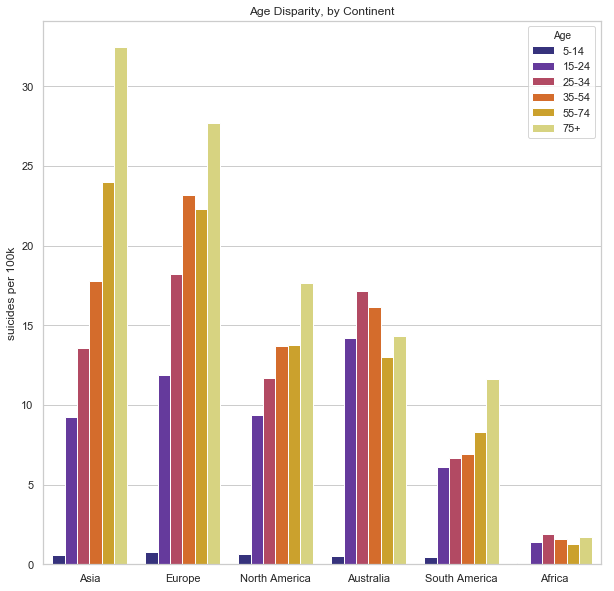

In [34]:
sb.set(style="whitegrid")
age_continent_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Age','Continent'])['suicides_no'].sum() 
                                          / train.groupby(['Age','Continent'])['population'].sum() * 100000 })
age_continent_results = age_continent_results.reset_index().sort_values('suicides_per_100k', ascending = False)

plt.figure(figsize=(10,10))
g = sb.barplot(x='Continent', y= 'suicides_per_100k', hue = 'Age' ,palette="CMRmap", ci = None,
               data = age_continent_results)

g.set(title='Age Disparity, by Continent',xlabel='',ylabel='suicides per 100k');

**Insights**

- For the Americas, Asia & Europe (which make up most of the dataset), suicide rate increases with age

## 2.9 As a country gets richer, does it’s suicide rate decrease?
It is well known that for almost every country, there is a high correlation between Year and GDP per capita, i.e. as time goes on, gdp per capita linearly increases.

We calculated the Pearson correlation between ‘year’ and ‘GDP per capita’ within each country, and found out the mean correlation was 0.878. This showed a strong positive linear relationship between the two variables and hence was a good indicator to explore the relationship between two variables and find out “does suicide rate in a country increase as time progresses?”

This was answered earlier in (2.5.2) - it depends on the country! Some countries are increasing with time, most are decreasing.

So, instead, we ask a slightly different question in 2.10.

In [35]:

def average(x):
    assert len(x) > 0
    return float(sum(x)) / len(x)

def pearson_def(x,y):
    
    x=list(x)
    y=list(y)
    
    
    n = len(x)
    
    avg_x = average(x)
    avg_y = average(y)
    diffprod = 0
    xdiff2 = 0
    ydiff2 = 0
    for idx in range(n):
        xdiff = x[idx] - avg_x
        ydiff = y[idx] - avg_y
        diffprod += xdiff * ydiff
        xdiff2 += xdiff * xdiff
        ydiff2 += ydiff * ydiff

    return diffprod / math.sqrt(xdiff2 * ydiff2)

mean_y = train.groupby('Country').apply(lambda x: pearson_def(x['Year'],x['GDPpercapita']))
print('mean correlation={} between ‘year’ and ‘GDP per capita’ within each country'.format(mean_y.mean()))

mean correlation=0.8780946558412762 between ‘year’ and ‘GDP per capita’ within each country


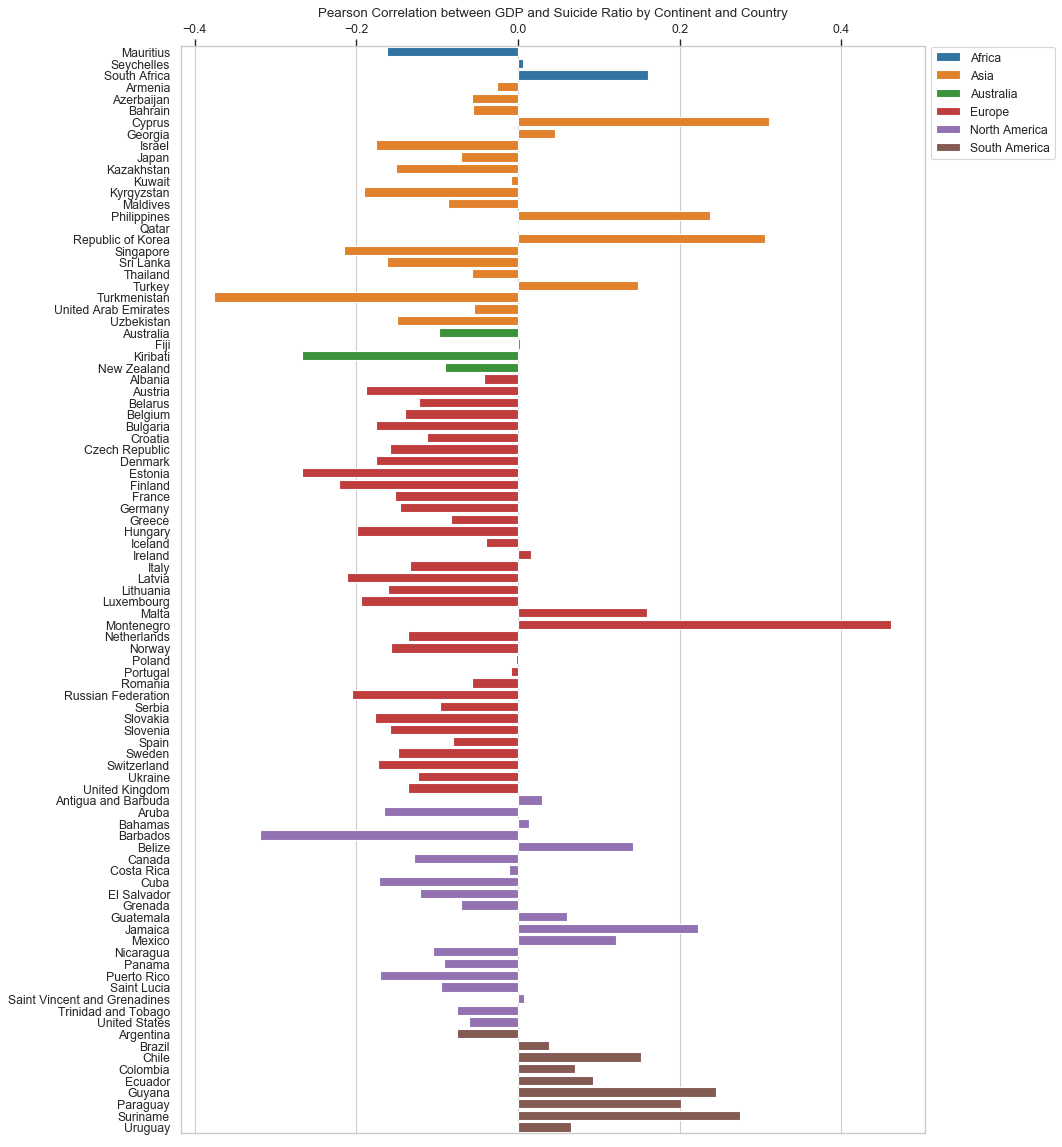

In [36]:
#GDP by Country and suicide rate
ctr_list = train['Country'].unique()
Continent = train.groupby(['Country','Continent'])['population'].sum().reset_index()
Continent.drop(columns=['population','Country'], axis = 1, inplace=True)
Continents = Continent['Continent'].tolist()
correlations = []

for ctr in ctr_list:
    temp_data = train.query("Country == @ctr")
    
    correlations.append(temp_data[['GDPpercapita', 'suicides_per_100k']].corr().iloc[0, 1])
#     correlations.append(pearson_def(temp_data['GDPpercapita'], temp_data['suicides_per_100k']))
    
correlations = np.array(correlations)

country_corr = pd.DataFrame({'Country':ctr_list, 'GDP_Suicide_Corr':correlations, 'Continent': Continents})

country_corr = country_corr.sort_values(['Continent','Country'])
fig, ax = plt.subplots(figsize=(12,18), dpi=80);
sb.barplot(data=country_corr, y='Country', x='GDP_Suicide_Corr',
            hue='Continent', dodge=False, palette='tab10',
            ).set(ylabel='');

ax.set_title('Pearson Correlation between GDP and Suicide Ratio by Continent and Country')
ax.xaxis.tick_top()
ax.xaxis.label.set_visible(False)
ax.legend(bbox_to_anchor=[1.0, 0.89]);

## 2.10 Do richer countries have a higher rate of suicide?
Instead of looking at trends within countries, here we take every country and calculate their mean GDP (per capita) across all the years in which data is available.<br> 
We then measure how this relates to the countries suicide rate across all those years.

The end result is one data point per country, intended to give a general idea of the wealth of a country and its suicide rate.

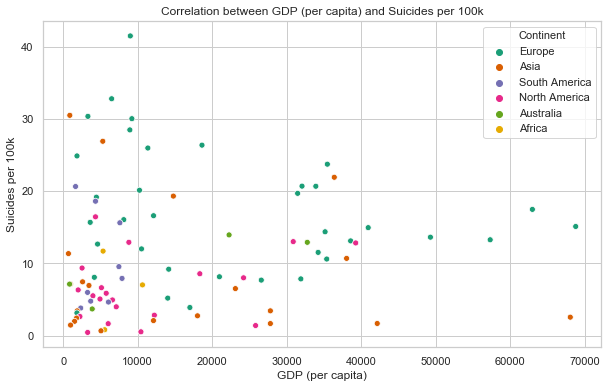

In [37]:
country_mean_gdp = pd.DataFrame({"suicides_per_100k": train.groupby(['Country', 'Continent'])['suicides_no'].sum() 
                                          / train.groupby(['Country','Continent'])['population'].sum() * 100000,
                                "GDPpercapita": train.groupby(['Country','Continent'])['GDPpercapita'].sum()
                                 /train.groupby(['Country','Continent'])['Year'].count()      
                                })

plt.figure(figsize=(10,6))
country_mean_gdp = country_mean_gdp.reset_index().sort_values('suicides_per_100k', ascending = False)
g = sb.scatterplot(y="suicides_per_100k", x="GDPpercapita", hue="Continent", palette = 'Dark2',
         data=country_mean_gdp)
g.set_title('Correlation between GDP (per capita) and Suicides per 100k');
g.set(xlabel= "GDP (per capita)", ylabel = "Suicides per 100k") ;

There are quite a few high leverage & residual countries that could have a significant impact on the fit of regression line (e.g. Lithuania, top left). So, we excluded those outliers and plotted the graph. We also now assessed the statistics of the model.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.957
Date:                Tue, 23 Jul 2019   Prob (F-statistic):             0.0891
Time:                        22:38:58   Log-Likelihood:                -298.52
No. Observations:                  87   AIC:                             601.0
Df Residuals:                      85   BIC:                             606.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5831      1.155      8.299      0.0

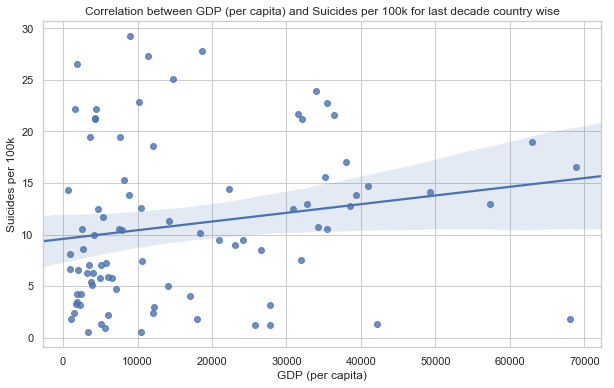

In [38]:
# Filtering the outlier values of greater than 30 

top_gdp = pd.DataFrame({"medianGDP": train.groupby('Country')['GDPpercapita'].mean()
                       ,"suicides_per_100k": train.groupby('Country')['suicides_per_100k'].mean()
                       })
top_gdp = top_gdp.reset_index()
top_gdp = top_gdp[top_gdp['suicides_per_100k']<=30]

plt.figure(figsize=(10,6));
# p=sb.lmplot(x ='medianGDP', y='suicides_per_100k',data = top_gdp, height = 6, aspect = 2);
p = sb.regplot(x='medianGDP',y='suicides_per_100k',data=top_gdp);
p.set_title('Correlation between GDP (per capita) and Suicides per 100k for last decade country wise');
p.set(xlabel= "GDP (per capita)", ylabel = "Suicides per 100k") ;
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata());
# print('slope: {}'.format(round(slope, 6)))
# print('intercept: {}'.format(round(intercept, 3)))
top_gdp[['medianGDP','suicides_per_100k']].corr()
X = np.array(top_gdp['medianGDP'])
y= np.array(top_gdp['suicides_per_100k'])
X = sm.add_constant(X)


m = sm.OLS(y, X)
model = sm.OLS(y, X)
results = m.fit()
print(results.summary())



The p-value of the model is **0.034** < 0.05. This means we can reject the hypothesis that a countries GDP (per capita) has no association with it’s rate of suicide (per 100k).<br>
The r-squared is 0.0544, so GDP (per capita) explains very little of the variance in suicide rate overall.
<br>
**What does all this mean?**
<br>
There is a weak but significant positive linear relationship - **richer countries are associated with higher rates of suicide**, but this is a weak relationship which can be seen from the graph above.



This line of best fit is represented by the equation below, where:

- Suicides = Suicides per 100k
- GDP = GDP per capita (in thousands, USD)<br>
                                    Suicides=8.7718+0.1115∗GDP

This means that, at a country level and over the time frame of this analysis (1985 - 2015), **an increase of GDP (per capita) by $8,967 was associated with 1 additional suicide, per 100k people, per year.**

## 2.11 The 5% highest risk instances in history
We will filter out data from 1985 only and look at what happens in the 3 decades following.

Here we are interested in the 5% highest risk (suicides/100k) demographics between 1986 and 2015.

We define a demographic as a year in a particular country, for some combination of sex & age. e.g. ‘United States, 2010, Female, 15 - 24’.

In order for a demographic to be in the top 5% for historic suicide rates, it would require a suicide rate exceeding 49.86 (per 100k) in that year.

5% Most At-Risk Instances in History
Volumes by Decade, Age & Sex


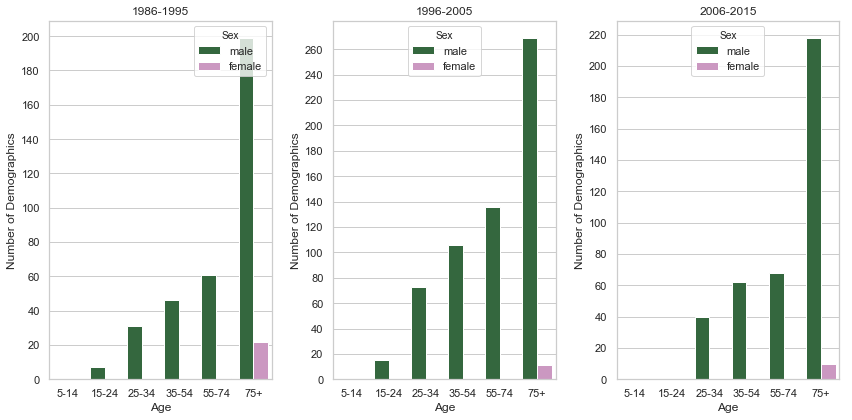

In [39]:
top  = round((train.shape[0]*5)/100)
demographic_most = train[train.Year!=1985][['Age','Sex','suicides_per_100k','Year','Time','suicides_no','population']]
demographic_most = demographic_most.sort_values('suicides_per_100k',ascending=False).head(top)
# demographic_most['Time'] = demographic_most['Year'].apply(lambda x: "1986 - 1995" if x <= 1995 
#                                                                else ('1996 - 2005' if x <= 2005 else "2006 - 2015"))
# demographic_most = pd.DataFrame({"suicides_per_100k": demographic_most.groupby(['Time', 'Age'])['suicides_no'].sum() 
#                                           / demographic_most.groupby(['Time', 'Age'])['population'].sum() * 100000,
                                     
#                                 })
demographic_most = demographic_most.reset_index()
df_1986_1995 = demographic_most[demographic_most.Time == '1986 - 1995']
df_1996_2005 = demographic_most[demographic_most.Time == '1996 - 2005']
df_2006_2015 = demographic_most[demographic_most.Time == '2006 - 2015']

# plt.figure(figsize=(10,6))
print('5% Most At-Risk Instances in History\nVolumes by Decade, Age & Sex')
fig, axs = plt.subplots(nrows = 1,ncols = 3, figsize=(12,6))


axs[0].set(yticks=list(np.arange(0,280,20)))

axs[1].set(yticks=list(np.arange(0,280,20)))
axs[2].set(yticks=list(np.arange(0,280,20)))

sb.countplot(x='Age', hue='Sex',palette="cubehelix",data = df_1986_1995, ax=axs[0]).set(title = '1986-1995', ylabel ='Number of Demographics');
sb.countplot(x='Age', hue='Sex',palette="cubehelix",data = df_1996_2005, ax=axs[1]).set(title='1996-2005', ylabel ='Number of Demographics');
sb.countplot(x='Age',hue='Sex',palette="cubehelix",data = df_2006_2015, ax=axs[2]).set(title='2006-2015', ylabel ='Number of Demographics');
fig.tight_layout();

In [40]:
print('% of top 5% risks instances in history between 1996 to 2005 = {}'.format(demographic_most[demographic_most.Year.between(1996,2005)].shape[0] * 100/ demographic_most.shape[0]))
print('Older Men % in top 5% risks instances in history = {}'.format(demographic_most[demographic_most.Age=='75+'].shape[0] * 100/ demographic_most.shape[0]))
print('% of female in top 5% risks instances in history = {}'.format(demographic_most[demographic_most.Sex=='female'].shape[0] * 100/demographic_most.shape[0]))
print('Ages of women in top 5% risks instances in history')
demographic_most[demographic_most.Sex=='female'].groupby('Age').count().reset_index()

% of top 5% risks instances in history between 1996 to 2005 = 44.36363636363637
Older Men % in top 5% risks instances in history = 53.018181818181816
% of female in top 5% risks instances in history = 3.2
Ages of women in top 5% risks instances in history


,Age,index,Sex,suicides_per_100k,Year,Time,suicides_no,population
0,5-14,0,0,0,0,0,0,0
1,15-24,0,0,0,0,0,0,0
2,25-34,0,0,0,0,0,0,0
3,35-54,0,0,0,0,0,0,0
4,55-74,1,1,1,1,1,1,1
5,75+,43,43,43,43,43,43,43


**Insights**

- 44.5% of these ‘high risk’ instances occurred between 1996 and 2005
- ~50% were in the 75+ age category
- 96.9% were a male demographic
- Of the 3.2% (42 instances) that were for women, 41/42 of these were in the 75+ demographic

# 3 Trends in Developed Countries
We think it would be useful to compare a few countries that people might think of as similar to the Canada (culturally, legally, economically).

## 3.1 Overall Trend

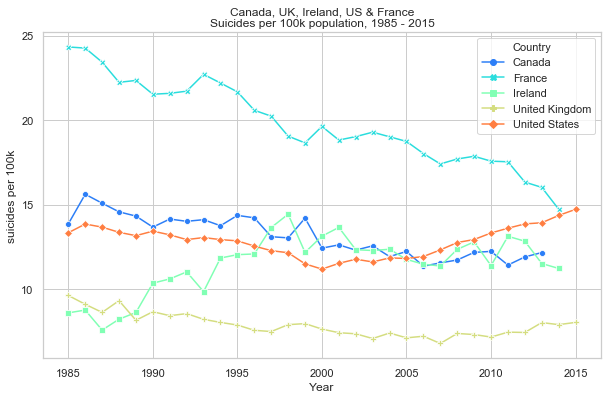

In [41]:
overtime_df = train[((train.Country=='Canada') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Year','Country','Age','Sex','suicides_no','population']]
overtime_df = pd.DataFrame({"suicides_per_100k": overtime_df.groupby(['Country', 'Year'])['suicides_no'].sum() 
                                          / overtime_df.groupby(['Country','Year'])['population'].sum() * 100000,
                                     
                                })

overtime_df = overtime_df.reset_index()
plt.figure(figsize=(10,6))
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', 
            palette='rainbow',markers=True, dashes=False, data=overtime_df, ci=None).set(yticks = [10,15,20,25]
    ,title="Canada, UK, Ireland, US & France\nSuicides per 100k population, 1985 - 2015", ylabel='suicides per 100k');

**Insights**

- The UK suicide rate has been consistently lowest since 1990, and has remained fairly static since ~1995
- France has historically had the highest rate, but is now roughly equal with America
- The US has the most concerning upward trend, linearly increasing by ~1/3 since 2000
- Canada is showing a downward trend. Canada's suicide rate is consistently lowering been since 1995 and presently, is at it's lowest rate since 1985.

## 3.2 By Gender
### 3.2.1 Male & Female Rates (over time)

Canada, UK, Ireland, US & France
Suicides per 100k population, 1985 - 2015


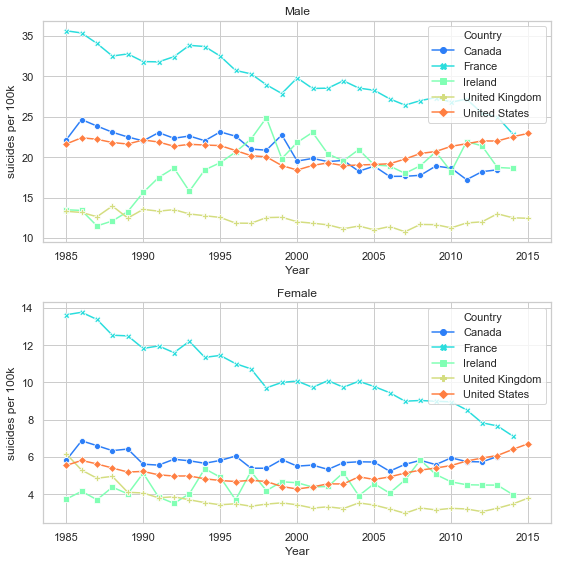

In [42]:
sex_overtime_df = train[((train.Country=='Canada') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Year','Country','Age','Sex','suicides_no','population']]
sex_overtime_df = pd.DataFrame({"suicides_per_100k": sex_overtime_df.groupby(['Country', 'Sex','Year'])['suicides_no'].sum() 
                                          / sex_overtime_df.groupby(['Country', 'Sex','Year'])['population'].sum() * 100000,
                                     
                                })
sex_overtime_df = sex_overtime_df.reset_index()
male_overtime_df = sex_overtime_df[sex_overtime_df.Sex=='male']
female_overtime_df = sex_overtime_df[sex_overtime_df.Sex=='female']
# g = sb.FacetGrid(sex_overtime_df, col='Sex', col_wrap = 1, height= 4, aspect =1)
# g.map(sb.lineplot, x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
# markers=True, dashes=False, data=df_25_34, ci=None)


fig, axs = plt.subplots(2,figsize=(8,8))


# axs[0].set(yticks=list(np.arange(0,14,2.5)))
# axs[1].set(yticks=list(np.arange(0,40,10)))
print('Canada, UK, Ireland, US & France\nSuicides per 100k population, 1985 - 2015')
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=male_overtime_df, ci=None,ax=axs[0]).set(title='Male',ylabel='suicides per 100k');
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=female_overtime_df, ci=None,ax=axs[1]).set(title='Female',ylabel='suicides per 100k');
fig.tight_layout();

**Insights**

- For the UK, there’s no obvious increase in the suicide rate for men and that can also be observed to an equal extent in women
- Rate for France has decreased to roughly rate same the US in 2015 for both Male and Female
- The different trend lines for men & women in Ireland is unusual - in 1990, the male rate increases, but the same can’t be observed for females
- For Canada, the suicide rate is decreasing roughly at the same rate.

### 3.2.2 Young to Middle-Aged Men
Here we restrict our analysis to:
- Men
- Ages “15-24”, “25-34” & “35-54”


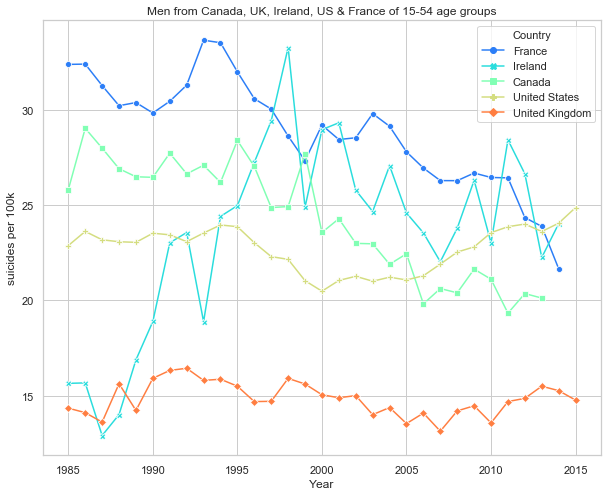

In [43]:
male_age_df = train[(train.Sex>='male') & ((train.Age=='15-24') | (train.Age=='25-34') | (train.Age=='35-54'))][['Country','Year','Age','suicides_no','population']]
male_age_df = male_age_df[(male_age_df.Country=='Canada') | 
                          (male_age_df.Country=='Ireland') | 
                          (male_age_df.Country=='United Kingdom') | 
                          (male_age_df.Country=='France') | 
                          (male_age_df.Country=='United States')]
male_age_df = pd.DataFrame({"suicides_per_100k": male_age_df.groupby(['Country','Year'])['suicides_no'].sum() 
                                          / male_age_df.groupby(['Country','Year'])['population'].sum() * 100000,
                                     
                                })
male_age_df = male_age_df.reset_index().sort_values('suicides_per_100k', ascending=False)

plt.figure(figsize=(10, 8))
g = sb.lineplot(x="Year", y="suicides_per_100k", 
                   hue="Country", style='Country', palette='rainbow',
                   markers=True, dashes=False, data=male_age_df, ci=None);
g.set(title='Men from Canada, UK, Ireland, US & France of 15-54 age groups',ylabel='suicides per 100k');

**Insights**

- Ireland’s trend over the 1990’s was very concerning It went from ~14 (per 100k, per year) to 33 between 1988 and 1998.
- Again, the US shows the most obvious and concerning upward trend
- Comparatively, for young to middle-aged men, the UK seems fairly flat across time
- Canada shows a remarkable downward trend. The rate went from ~29 to ~19 from year 1995 to 2006 - a decrease of ~35%.

### 3.2.3 Men - Ages 15-24, 25-34 & 35-54

Canada, UK, Ireland, US & France
 Suicides per 100k for 3 age groups


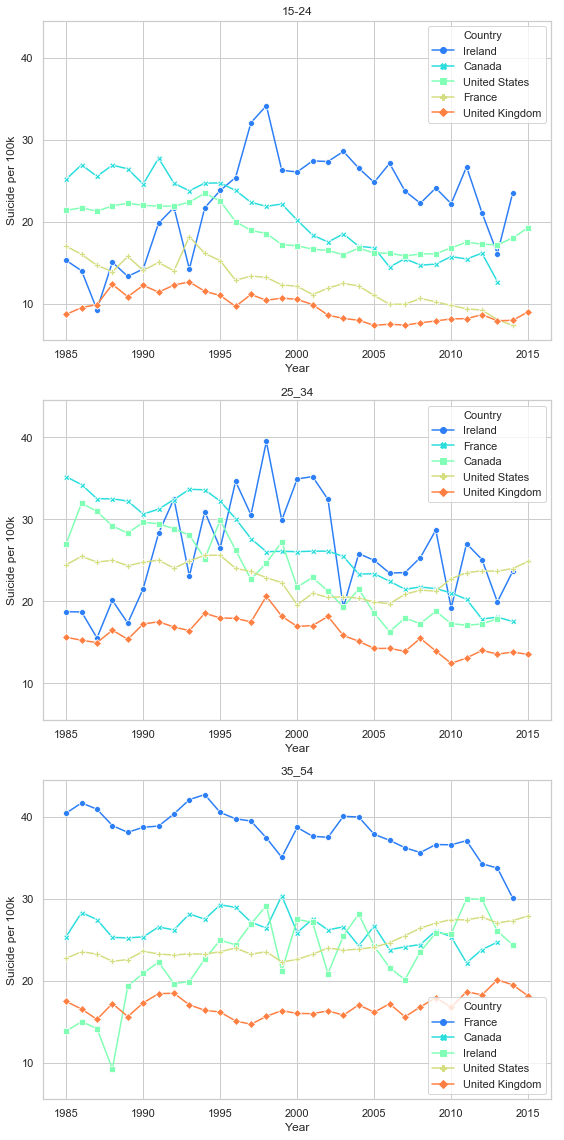

In [44]:
male_df = train[(train.Sex>='male') & ((train.Age=='15-24') | (train.Age=='25-34') | (train.Age=='35-54'))][['Country','Year','Age','suicides_no','population']]
male_df = male_df[(male_df.Country=='Canada') | 
                          (male_df.Country=='Ireland') | 
                          (male_df.Country=='United Kingdom') | 
                          (male_df.Country=='France') | 
                          (male_df.Country=='United States')]
male_df = pd.DataFrame({"suicides_per_100k": male_df.groupby(['Country','Year','Age'])['suicides_no'].sum() 
                                          / male_df.groupby(['Country','Year','Age'])['population'].sum() * 100000,
                                     
                                })
male_df = male_df.reset_index().sort_values('suicides_per_100k', ascending=False)

df_15_24 = male_df[male_df.Age=='15-24']
df_25_34 = male_df[male_df.Age=='25-34']
df_35_54 = male_df[male_df.Age=='35-54']



# df_15_24['suicides_per_100k'] = df_15_24.groupby('Year')
print('Canada, UK, Ireland, US & France\n Suicides per 100k for 3 age groups')
fig, axs = plt.subplots(3,figsize=(8,16), sharey=True)

axs[0].set(yticks=list(np.arange(0,60,10)))
axs[1].set(yticks=list(np.arange(0,60,10)))
axs[2].set(yticks=list(np.arange(0,60,10)))

sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=df_15_24, ci=None,ax=axs[0]).set(title='15-24', ylabel='Suicide per 100k');
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=df_25_34, ci=None,ax=axs[1]).set(title='25_34', ylabel='Suicide per 100k');
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=df_35_54, ci=None,ax=axs[2]).set(title='35_54', ylabel='Suicide per 100k');
fig.tight_layout();

**Insights**

- Canada rates for men in the ‘15-24’ and ‘25-34’ categories appear to be decreasing, which is a positive thing.
- Canada rates for men in the ‘35-54’ categories appear flat & slightly decreasing

## 3.3 Recent trends in developed countries
We are really more interested in data from recent years, so we will restrict the timeframe to 2010 onwards for both gender from Canada ,UK, Ireland, America & France
### 3.3.1 Proportion of suicides that are Men

Proportion(Percentage) of suicides that were Male & Female
 2010 - 2015 only for Canada, UK, Ireland, US & France


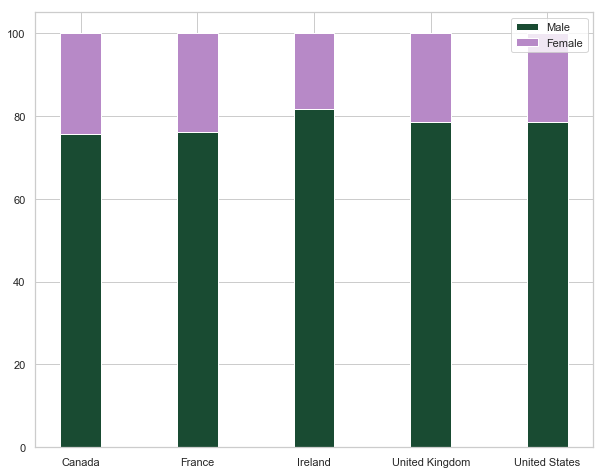

In [45]:
recent_df = train[(train.Year>=2010) & ((train.Country=='Canada') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Country','Sex','suicides_no','population']]
recent_df = pd.DataFrame({"suicides_per_100k": recent_df.groupby(['Country', 'Sex'])['suicides_no'].sum() 
                                          / recent_df.groupby(['Country', 'Sex'])['population'].sum() * 100000,
                                     
                                })
recent_df = recent_df.reset_index()
print('Proportion(Percentage) of suicides that were Male & Female\n 2010 - 2015 only for Canada, UK, Ireland, US & France')

r = recent_df.Country.unique()
greenBars = recent_df[recent_df.Sex=='male']['suicides_per_100k']   #male
orangeBars =recent_df[recent_df.Sex=='female']['suicides_per_100k']   #female 
plt.figure(figsize=(10,8))
df = pd.DataFrame({ 'greenBars': list(greenBars),
                    'orangeBars': list(orangeBars)
})
barWidth = 0.35
totals = [i + j for i, j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]

p1=plt.bar(r, greenBars, color='#194B32', edgecolor='white', width=barWidth);   #b5ffb9
# Create orange Bars
p2 = plt.bar(r, orangeBars, bottom=greenBars, color='#B789C7', edgecolor='white', width=barWidth);  #f9bc86

plt.legend((p1[0], p2[0]), ('Male', 'Female'));

**Insights**

- Similar pattern as seen throughout the analysis - men make up ~ 75% of deaths by suicide
- The highest proportion is in Ireland - ~82% male
- The lowest proportion is for Canada - ~75% male

### 3.3.2 Age Rates

Proportion of suicides for the 5 Age groups
Only for Canada, UK, Ireland, US & France


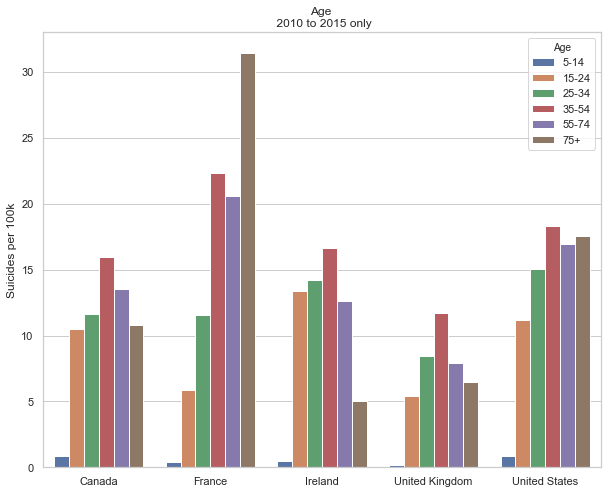

In [46]:
recent_age_df = train[(train.Year>=2010) & ((train.Country=='Canada') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Country','Age','Sex','suicides_no','population']]
recent_age_df = pd.DataFrame({"suicides_per_100k": recent_age_df.groupby(['Country','Age'])['suicides_no'].sum() 
                                          / recent_age_df.groupby(['Country','Age'])['population'].sum() * 100000,
                                     
                                })
recent_age_df = recent_age_df.reset_index().sort_values(['Country','Age'], ascending=False)
recent_age_df['Age'] = recent_age_df['Age'].apply(lambda x: 0 if x=='75+' else(1 if x=='55-74' else (2 if x=='35-54' else(3 if x=='25-34' else (4 if x=='15-24' else 5 )) )))

recent_age_df = recent_age_df.reset_index().sort_values(['Country','Age'])
recent_age_df['Age'] = recent_age_df['Age'].apply(lambda x: '75+' if x==0 else('55-74' if x==1 else ('35-54' if x==2 else('25-34' if x==3 else ( '15-24'if x==4 else '5-14' )) )))
print('Proportion of suicides for the 5 Age groups\nOnly for Canada, UK, Ireland, US & France')
plt.figure(figsize=(10, 8));
g=sb.barplot(x = 'Country', y='suicides_per_100k',hue='Age',data = recent_age_df);

g.set(title='Age \n 2010 to 2015 only', ylabel = "Suicides per 100k", xlabel='');

**Insights**

- There’s a huge difference in the ‘trend’ of suicide rates as age varies within each country
- Suicide rate increases with age for France, and the US (to a lesser extent)
- Those aged 35-54 at the highest risk in Canada, Ireland and the UK which follow closer to a gaussian distribution

### 3.3.3 Male & Female Rates (for different age categories)

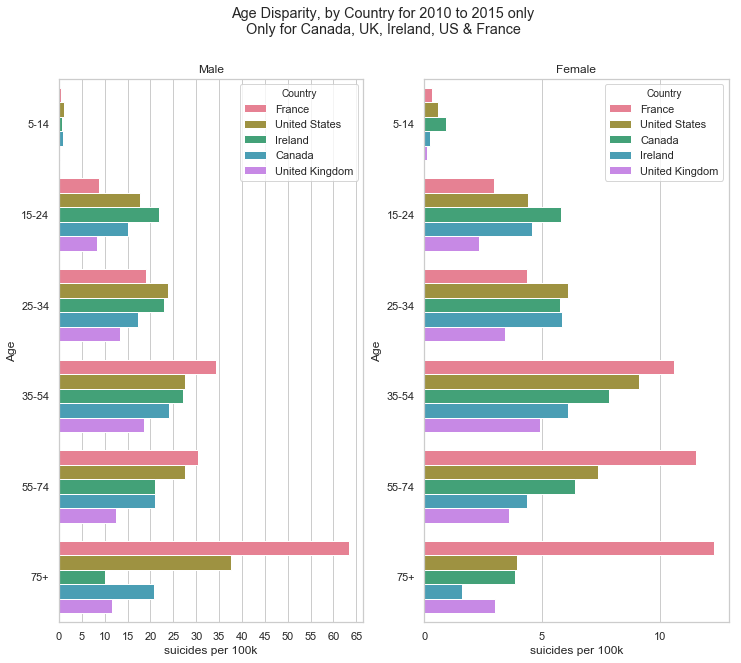

In [47]:
recent_sex_age_df = train[(train.Year>=2010) & ((train.Country=='Canada') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Country','Age','Sex','suicides_no','population']]
recent_sex_age_df = pd.DataFrame({"suicides_per_100k": recent_sex_age_df.groupby(['Country','Age','Sex'])['suicides_no'].sum() 
                                          / recent_sex_age_df.groupby(['Country','Age','Sex'])['population'].sum() * 100000,
                                     
                                })
recent_sex_age_df = recent_sex_age_df.reset_index().sort_values('suicides_per_100k', ascending=False)
recent_male_age_df = recent_sex_age_df[recent_sex_age_df.Sex=='male']
recent_female_age_df = recent_sex_age_df[recent_sex_age_df.Sex=='female']

fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(12,10), sharex=False)
fig.suptitle('Age Disparity, by Country for 2010 to 2015 only\nOnly for Canada, UK, Ireland, US & France')
axs[0].set(xticks=list(np.arange(0,80,5)))
axs[1].set(xticks=list(np.arange(0,80,5)))

axs[0].set_title('Male')
axs[1].set_title('Female')


# p1.legend(loc='center right', bbox_to_anchor=(1.25, 1.2), ncol=6);
p1 = sb.barplot(y='Age',x='suicides_per_100k',hue='Country', palette="husl",data = recent_male_age_df, ax=axs[0], ci=None).set(xlabel='suicides per 100k');
p2 = sb.barplot(y='Age',x='suicides_per_100k',hue='Country', palette="husl",data = recent_female_age_df, ax=axs[1], ci=None).set(xlabel='suicides per 100k');

**Insights**

- In the US, suicide rate for men and women continues to increase with age, but the female rate decreases in old age
- This weird disparity is only present in the US
- Canada has the lowest suicide rate in every Gender-Age group

## 3.4 HDI
The Human Development Index (HDI) is a measure of average achievement in key dimensions of human development: a long and healthy life, being knowledgeable and have a decent standard of living. 

A country scores a higher HDI when the above indicated parameters of human development is higher.

As HDI for year column contains missing values to around 70%, the data is filtered for recent years i.e., 2006 to 2016 and those countries with no HDI were removed.

Countries were divided based on the HDI categories - Very High, High, Medium and Low representing Human Development Index categories

In [2]:
data_withHDI = train[(train.hdi.notnull()) & (train.Time=='2006 - 2015')]
data_withHDI = data_withHDI.groupby(['hdi'])[['population','suicides_no']].sum().reset_index()
data_withHDI['suicide_rate'] = data_withHDI['suicides_no']*100000/data_withHDI['population']
# HDI Categories
data_withHDI['hdi_categories'] = np.where(data_withHDI['hdi'] >=0.8, "Very High",
                             np.where(data_withHDI['hdi'].between(0.7,0.799), "High",
                             np.where(data_withHDI['hdi'].between(0.555,0.699),"Medium","Low")))

# Plot and Correlation
plt.figure(figsize=(12,7))
ax = sb.scatterplot(x="hdi", y="suicide_rate", hue= 'hdi_categories', palette=['yellow','orange','red'],data=data_withHDI)
ax.set(ylabel='Suicide Rate', xlabel='HDI', title = 'Suicide Rate by HDI across countries falling in different HDI categories')

data_withHDI[['hdi','suicide_rate']].corr()

NameError: name 'train' is not defined

**Insights**

- There exist a correlation of 0.43 (weak positive correlation) between suicide rates and HDI, indicating that suicide rates are high among countries with high human development index.

## 3.5 Generation
In this section we want to find out which generation is more susceptible to suicides and also analyze the trend over the years. 

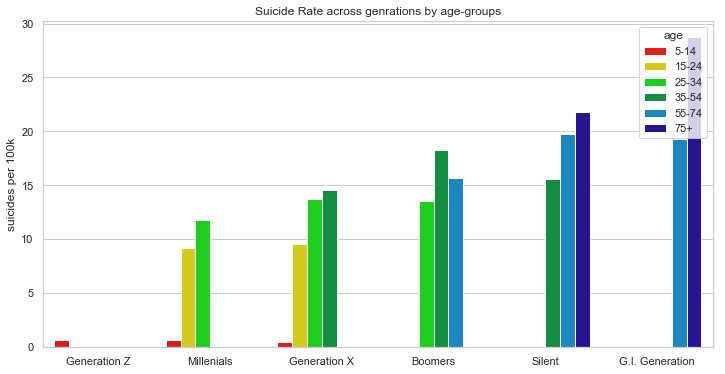

In [49]:
age_gen =  train.groupby(['Generation','Age'])[['population','suicides_no']].sum().reset_index()
age_gen['suicides_per_100k'] = age_gen.suicides_no*100000/age_gen.population
age_gen = age_gen.sort_values('suicides_per_100k', ascending=False)
plt.figure(figsize=(12,6))

g = sb.barplot(x = 'Generation',y = 'suicides_per_100k', palette = 'nipy_spectral_r',hue='Age',data=age_gen);
g.legend(loc =1, title = 'age');
g.set(ylabel='suicides per 100k', xlabel='', title = 'Suicide Rate across genrations by age-groups');

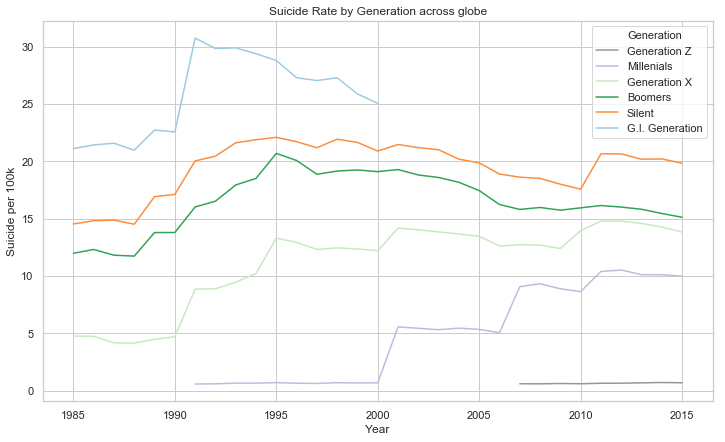

In [50]:
plt.figure(figsize=(12,7))
df_gen = train.groupby(['Year','Generation'])[['population','suicides_no']].sum().reset_index()
df_gen['suicide_rate'] = df_gen['suicides_no']*100000/df_gen['population']
ax = sb.lineplot(x="Year", y="suicide_rate",hue = 'Generation',palette='tab20c_r',data=df_gen,  legend="full");
ax.set(ylabel='Suicide per 100k', xlabel='Year', title = 'Suicide Rate by Generation across globe');

**Insights**
- We could say Boomers (born 1946-1964), Silent (born 1921-1945) and Generation X (born 1965-1976) are much more suicidal.
- Rate for Generation Z (born 1996 onwards) has plateaued since 2006 but, cannot be assertive due to lack of data.
- Rate for Millennials (born 1977 - 1995) is increasing at an alarming rate.
- Rate for GI Generation (born 1920 or before) appears to be decreasing after 1991 but, cannot be assertive due to lack of data. 

## 3.5 2007-08 Recession
To analyze if there was a rise in suicide during 2007-08 recession, we used the GDP data between years 2005 and 2008 and number of suicides during the same time period.<br>
We plotted the Countries that showed an 'Increasing Suicide Rate Trend.'

In [51]:
recession_df = train[train['Year'].between(2005,2008)][['Country','Year','GDPpercapita','suicides_no','population']]

# recession_df = recession_df.groupby(['Country','Year'])['suicides_no','population'].sum().reset_index()
recession_df = recession_df.groupby(['Country','Year']).agg({'suicides_no': 'sum',
                                                            'population': 'sum',
                                                            'GDPpercapita': 'mean'}).reset_index()
recession_df['suicide_rate'] = recession_df['suicides_no']*100000 / recession_df['population']

recession_trends = []
for country in recession_df.Country.unique():
    country_trend = recession_df[recession_df['Country'] == country]
    
    X = np.array(recession_df['GDPpercapita']).reshape([-1,1])
    y = np.array(recession_df['suicide_rate']).reshape([-1,1])
    
    model = LinearRegression()
    diff = model.fit(X,y).coef_[0][0]
    
    trends.append([country,diff])

    
df_recession_trends = pd.DataFrame(trends,columns=['Country','factor']).sort_values(by='factor')
df_recession_trends = df_recession_trends[df_recession_trends.factor>0.03]

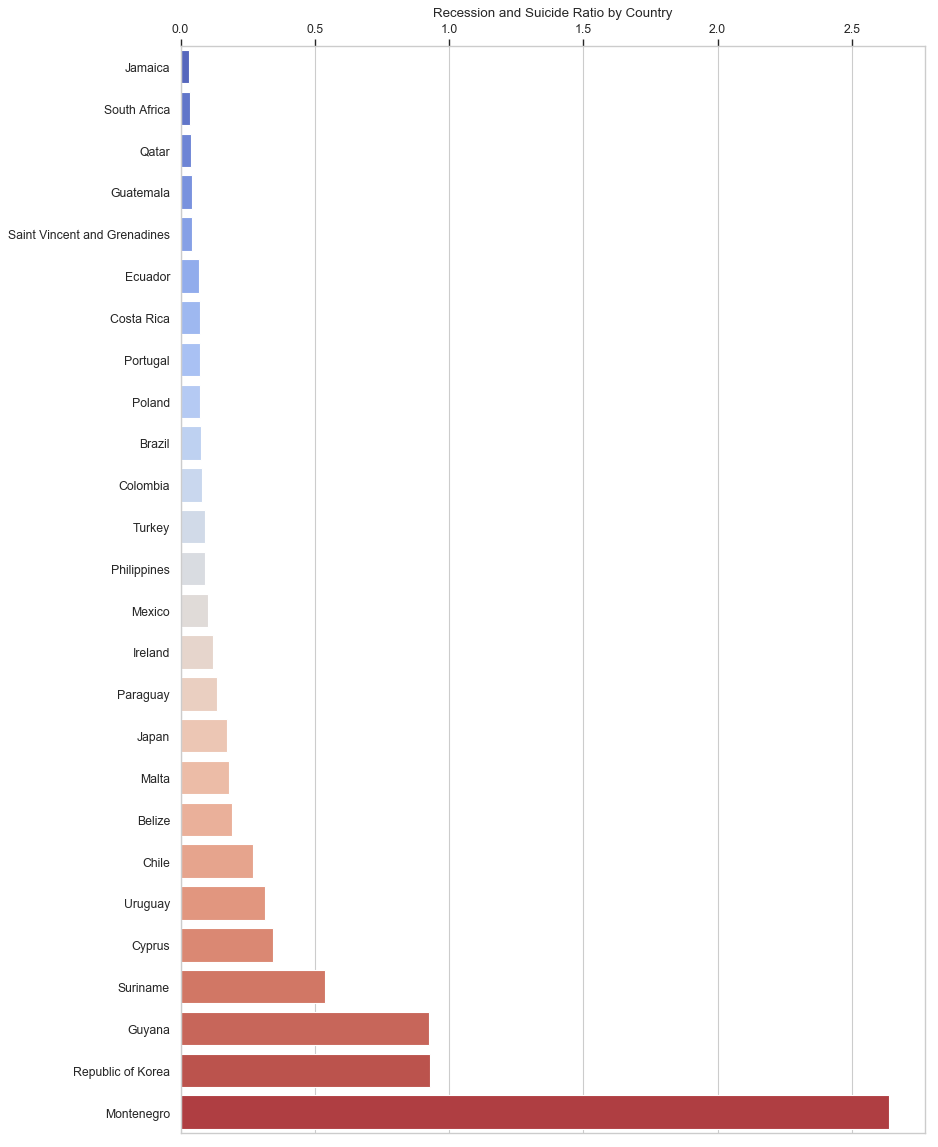

In [52]:
fig, ax = plt.subplots(figsize=(12,18), dpi=80);
sb.barplot(data=df_recession_trends, y='Country', x='factor',
            dodge=False, palette='coolwarm', ci=None
            ).set(ylabel='');

ax.set_title('Recession and Suicide Ratio by Country')
ax.xaxis.tick_top();
ax.xaxis.label.set_visible(False);

In [53]:
mean_y = recession_df.groupby('Country').apply(lambda x: x[['GDPpercapita','suicides_no']].corr().iloc[0, 1])
print('Correlation between GDP of Countries and their suicide rate during Years 2005-2008 ={}'.format(mean_y.mean()))

Correlation between GDP of Countries and their suicide rate during Years 2005-2008 =-0.10534690279838384


**Insights**
- Out of 90 Countries available in the dataset, only 26 countries showed significant positive trend in suicide rate during the recession
- Also, a negative and weak negative correlation is seen between GDP (per capita) and suicide rate for the Years 2005 to 2008 

# 4. External Factor
One can argue that temperature is related to sun exposure, sun exposure is related to Vitamin D and Vitamin D has been studied as a factor related to mental health and depression

One can also argue that sun exposure is related to Melatonin, which in turn is related to sleep quality and sleep quality is related to mental health

That's why we decided to briefly explore these two factors together. Let's see what our data tells us.

The data was obtained on kaggle and was processed and filtered to only show data by year and countries included in our suicide data.
We merged the dataset with data from 'Climate Change: Earth Surface Temperature Data' to get the average 

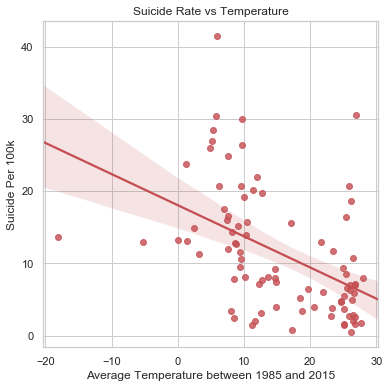

In [54]:
# suicide and Temperature
country_data = train.groupby('Country')['suicides_no','population'].sum().reset_index()
country_data['suicides_no'] = country_data['suicides_no'] * 100000 / country_data['population']
country_year_temperature_data = pd.read_csv('./cleaned_temperature_data.csv')

country_temperature_data = country_year_temperature_data.groupby('Country').mean().reset_index()
country_temperature_data.drop(country_temperature_data.columns[country_temperature_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
temperature_data = country_data.merge(country_temperature_data,
                                      left_index=True,
                                      on='Country',
                                      how='left')

# new = pd.concat([country_data,country_temperature_data], join = 'left', axis = 1)
plt.figure(figsize=(6,6));
# fig, ax = standard_plot('Suicide Per 100k versus Temperature', 'Average Temperature', 'Suicide Per 100k')
# fig.set_size_inches(8,8)
g = sb.regplot(data = temperature_data, x='AverageTemperature',
              y='suicides_no', color='C3')
g.set(xlabel='Average Temperature between 1985 and 2015', ylabel='Suicide Per 100k', title = 'Suicide Rate vs Temperature');

In [55]:
print('negative correlation between Average Temperature of a Country and its suicide rate={}'.format(temperature_data[['AverageTemperature', 'suicides_no']].corr().iloc[0, 1]))

negative correlation between Average Temperature of a Country and its suicide rate=-0.4741188338498785


**Insights**
- For the countries in our data average temperature play a role!
- We found a weak negative correlation between Average Temperature of a Country and its suicide rate. This means that countries with warm temperature has lesser Suicide rate. But, Temperature is not the only factor.

# 5. Conclusions

1. Suicide rates are **decreasing globally**.
2. Of those countries that show clear linear trends over time, **2/3 are decreasing**.
3. On average, suicide rate **increases with age**.
4. This remains true when controlling for continent in the Americas, Asia & Europe, but not for Africa.
5. There is a **weak positive relationship between a countries GDP (per capita) and suicide rate**.
6. The **highest suicide rate** ever recorded in a demographic (for 1 year) is **225** (per 100k population).
7. There is an **overrepresentation of men** in suicide deaths at every level of analysis (globally, at a continent and country level). 
8. Globally, the male rate is **~3.5x higher**.
9. Average temperature of a country has a weak negative correlation with it's suicide rate. But, this is not a Universal factor.

## References
United Nations Development Program. (2018). Human development index (HDI). Retrieved from http://hdr.undp.org/en/indicators/137506

World Bank. (2018). World development indicators: GDP (current US$) by country:1985 to 2016. Retrieved from http://databank.worldbank.org/data/source/world-development-indicators#

[Szamil]. (2017). Suicide in the Twenty-First Century [dataset]. Retrieved from https://www.kaggle.com/szamil/suicide-in-the-twenty-first-century/notebook

World Health Organization. (2018). Suicide prevention. Retrieved from http://www.who.int/mental_health/suicide-prevention/en/

https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data#GlobalLandTemperaturesByCountry.csv